In [ ]:
#!pip install alibi
#!pip install dice_ml

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from alibi.explainers.ale import ALE, plot_ale


In [6]:
names = [
    'id', 
    'clump_thickness', 
    'cell_size_uniformity', 
    'cell_shape_uniformity',
    'marginal_adhesion',
    'epithelial_cell_size',
    'bare_nuclei',
    'bland_chromatin',
    'normal_nucleoli',
    'mitoses',
    'class'
]

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
df1 = pd.read_csv(url, names=names)
df1.head(10)
# Dataset is now stored in a Pandas Dataframe

,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


In [7]:
# remove NaN values
dataset1 = df1.replace('?', np.NaN)
dataset1.dropna(inplace=True)

# remove non-feature col
dataset1.drop(columns=['id'], inplace=True)


# convert labels to M=1 and B=0
dataset1['class'] = (dataset1['class'] == 4).astype(int)
dataset1 = dataset1.astype(np.float64)
dataset1['class'] = dataset1['class'].astype('int32')
dataset1.head(10)

,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0
5,8.0,10.0,10.0,8.0,7.0,10.0,9.0,7.0,1.0,1
6,1.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,1.0,0
7,2.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,0
8,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,0
9,4.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,0


In [8]:
dataset1.dtypes

clump_thickness          float64
cell_size_uniformity     float64
cell_shape_uniformity    float64
marginal_adhesion        float64
epithelial_cell_size     float64
bare_nuclei              float64
bland_chromatin          float64
normal_nucleoli          float64
mitoses                  float64
class                      int32
dtype: object

Considering the definitions of continuous and discrete data, this analisys considers all variables as continuous data. 

In [52]:
# Split Train and Test datasets
# Shuffle the data and define the train and test set:
X = dataset1.iloc[:,:-1].values
y = dataset1.iloc[:,9:].values

#X = dataset1.drop(columns=['class'])
#y = dataset1['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42 )
#X_train = X_train.astype(np.float64)
#X_test = X_test.astype(np.float64)

In [53]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
accuracy_score(y_test, lr.predict(X_test))

0.9532163742690059

**Calculate Accumulated Local Effects**

There are several options for explaining the classifier predictions using ALE. We define two prediction functions, one in the unnormalized logit space and the other in probability space, and look at how the resulting ALE plot interpretation changes.

In [64]:
feature_names = names[1:-1]
target_names = [0,1]

In [65]:
logit_fun_lr = lr.decision_function
proba_fun_lr = lr.predict_proba

In [66]:
logit_ale_lr = ALE(logit_fun_lr, feature_names=feature_names)
proba_ale_lr = ALE(proba_fun_lr, feature_names=feature_names)


In [67]:
logit_exp_lr = logit_ale_lr.explain(X_train)
proba_exp_lr = proba_ale_lr.explain(X_train)

**ALE in logit space**


We first look at the ALE plots for explaining the feature effects towards the unnormalized logit scores:

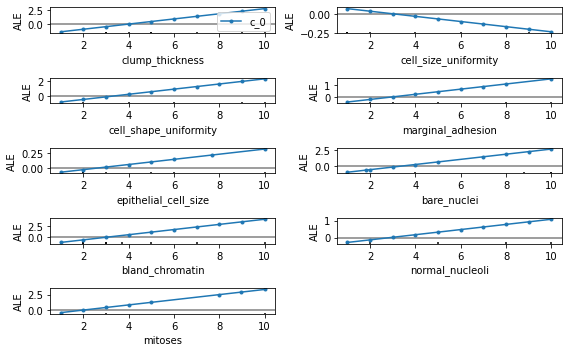

In [68]:
plot_ale(logit_exp_lr, n_cols=2, fig_kw={'figwidth': 8, 'figheight': 5}, sharey=None);

Furthermore, the units of the ALE plots here are in logits, which means that the feature effect at some feature value will be a positive or negative contribution to the logit of each class with respect to the mean feature effect.

Let’s look at the interpretation of the feature effects for “petal length” in more detail: 
https://docs.seldon.io/projects/alibi/en/stable/examples/ale_classification.html

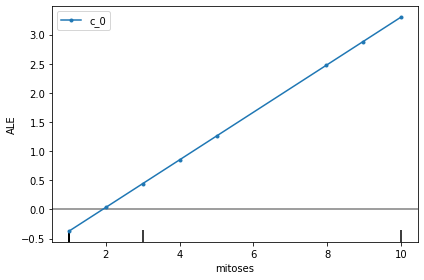

In [72]:
plot_ale(logit_exp_lr, features=[8]);

We can go into a bit more detail about the “mean response” at the mitoses count above 2. 
First, we calculate the mean response (in logit space) of the model on the training set:

In [70]:
mean_logits = logit_fun_lr(X_train).mean(axis=0)
mean_logits

-1.6566467790627888

Next, we find instances for which the feature “mitoses” is close to 2 and look at the predictions for these:

In [73]:
lower_index = np.where(logit_exp_lr.feature_values[2] < 2)[0][-1]
upper_index = np.where(logit_exp_lr.feature_values[2] > 2)[0][0]
subset = X_train[(X_train[:, 2] > logit_exp_lr.feature_values[2][lower_index])
                 & (X_train[:, 2] < logit_exp_lr.feature_values[2][upper_index])]
print(subset.shape)

(45, 9)


In [74]:
subset_logits = logit_fun_lr(subset).mean(axis=0)
subset_logits

-3.983308754742686

In [75]:
mean_logits - subset_logits

2.3266619756798974

**ALE in probability space**

We now turn to interprting the ALE plots for explaining the feature effects on the probabilities of each class.

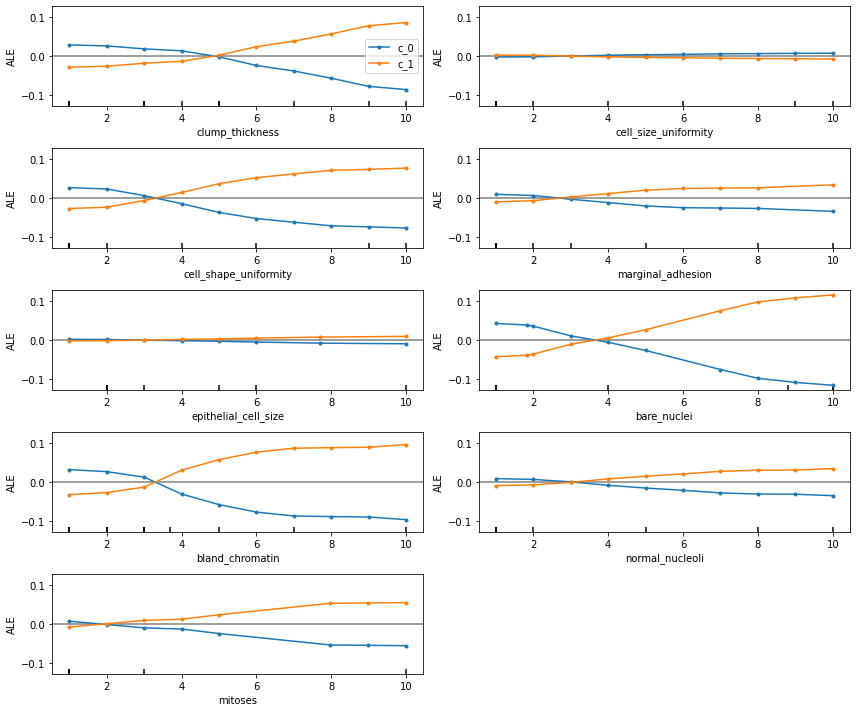

In [80]:
plot_ale(proba_exp_lr, n_cols=2, fig_kw={'figwidth': 12, 'figheight': 10});

**ALE for gradient boosting**

In [81]:
from sklearn.ensemble import GradientBoostingClassifier

In [112]:
gb = GradientBoostingClassifier()
gbModel=gb.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [113]:
accuracy_score(y_test, gb.predict(X_test))

0.9473684210526315

In [84]:
logit_fun_gb = gb.decision_function
proba_fun_gb = gb.predict_proba
logit_ale_gb = ALE(logit_fun_gb, feature_names=feature_names)
proba_ale_gb = ALE(proba_fun_gb, feature_names=feature_names)
logit_exp_gb = logit_ale_gb.explain(X_train)
proba_exp_gb = proba_ale_gb.explain(X_train)

**ALE in logit space**

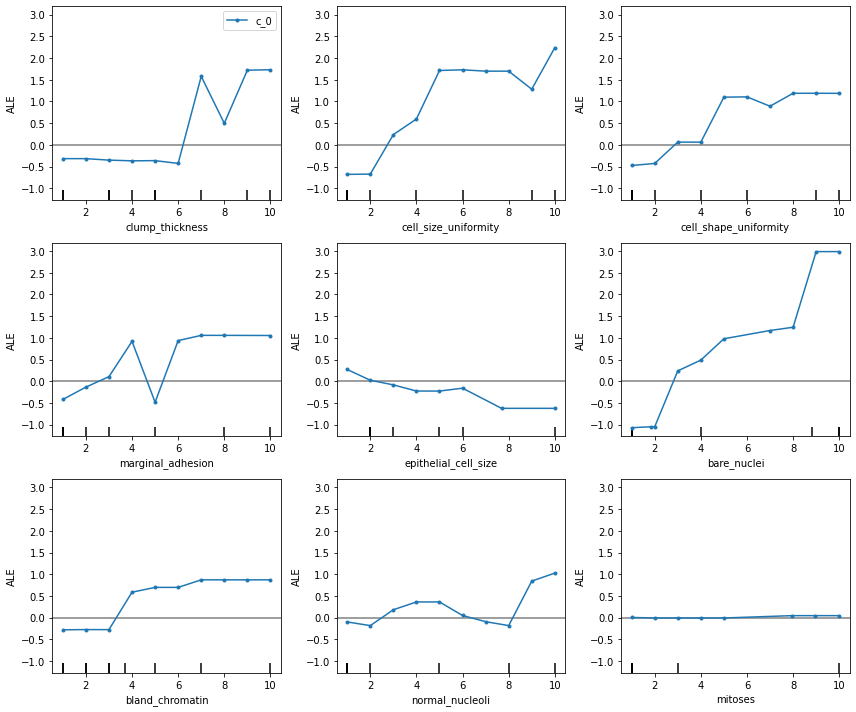

In [88]:
plot_ale(logit_exp_gb, n_cols=3, fig_kw={'figwidth': 12, 'figheight': 10});

In [86]:
gb.feature_importances_

array([3.35994621e-02, 7.30843526e-01, 7.07433213e-02, 1.16027941e-02,
       1.07205330e-02, 1.02819811e-01, 2.00148107e-02, 1.93385851e-02,
       3.17156868e-04])

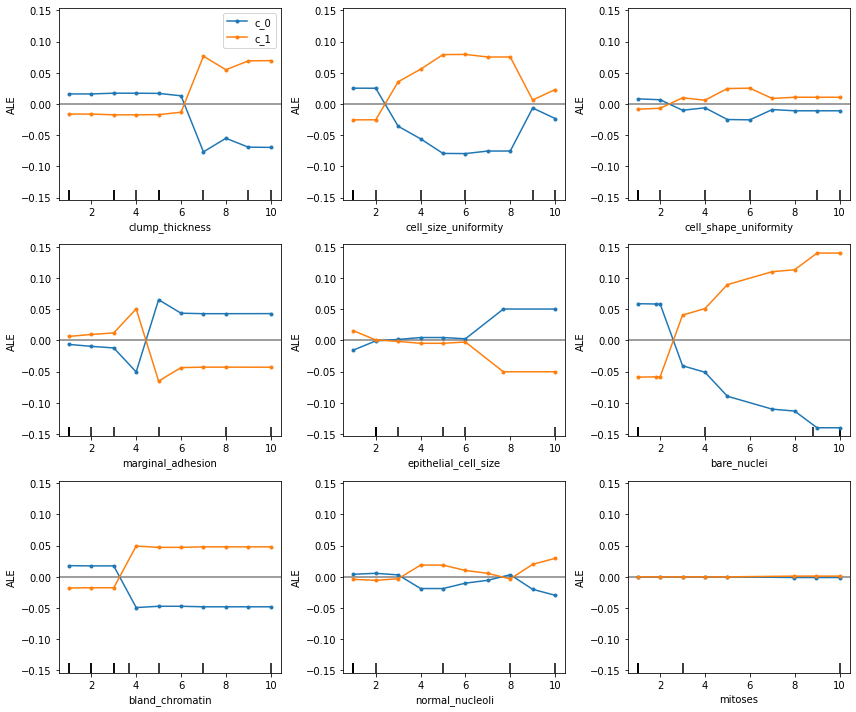

In [87]:
plot_ale(proba_exp_gb, n_cols=3, fig_kw={'figwidth': 12, 'figheight': 10});

Comparing ALE between models

In [93]:
# This plot should work, need to explore labelling options.
plot_ale(proba_exp_lr, features=[2, 3], targets= [0], ax=ax, line_kw={'label': 'LR'});
plot_ale(proba_exp_gb, features=[2, 3], targets= [0], ax=ax, line_kw={'label': 'GB'})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f07c199f4e0>,
      dtype=object)

In [8]:
def correlation_matrix(y, X, is_plot=False):
  # Calculate and plot the correlation symmetrical matrix
  # Return:
  # yX - concatenated data
  # yX_corr - correlation matrix, pearson correlation of values from -1 to +1
  # yX_abs_corr - correlation matrix, absolute values
  
  yX = pd.concat([y, X], axis=1)
  yX = yX.rename(columns={0: 'TARGET'})  # rename first column

  print("Function correlation_matrix: X.shape, y.shape, yX.shape:", X.shape, y.shape, yX.shape)
  print()

  # Get feature correlations and transform to dataframe
  yX_corr = yX.corr(method='pearson')

  # Convert to abolute values
  yX_abs_corr = np.abs(yX_corr) 
  
  if is_plot:
    plt.figure(figsize=(10, 10))
    plt.imshow(yX_abs_corr, cmap='RdYlGn', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
    plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
    plt.suptitle('Pearson Correlation Heat Map (absolute values)', fontsize=15, fontweight='bold')
    plt.show()
  
  return yX, yX_corr, yX_abs_corr

Function correlation_matrix: X.shape, y.shape, yX.shape: (546, 9) (546,) (546, 10)



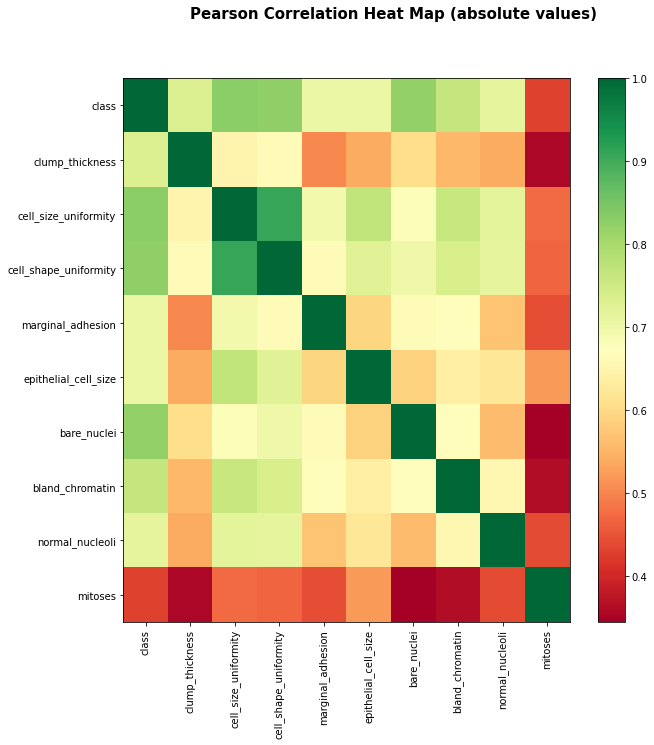

In [9]:
# Build the correlation matrix for the train data
yX, yX_corr, yX_abs_corr = correlation_matrix(y_train, X_train, is_plot=True)

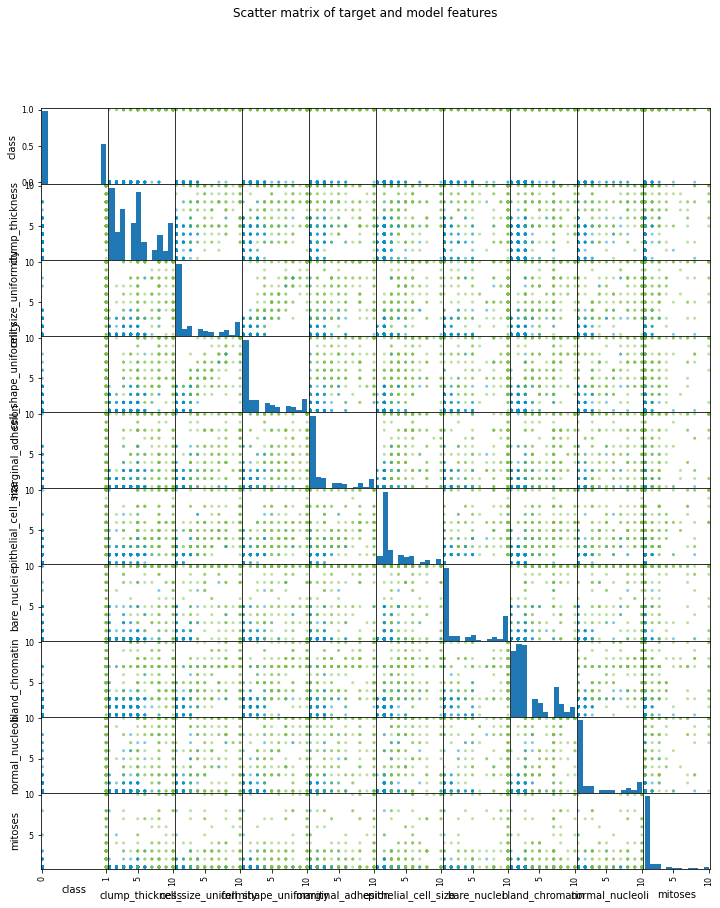

In [11]:
color_map = {0: '#0392cf', 1: '#7bc043'}  # 0 (negative class): blue, 1 (positive class): green
colors = yX['class'].map(lambda x: color_map.get(x))
pd.plotting.scatter_matrix(yX, alpha=0.5, color=colors, figsize=(12,14), diagonal='hist', hist_kwds={'bins':12})
plt.suptitle('Scatter matrix of target and model features')
plt.show()

# Explaining Tree Models with Interventional Feature Perturbation Tree SHAP

This example shows how to apply interventional Tree SHAP to compute shap values exactly for an xgboost model fitted to the Wisconsin Breast Cancer dataset (binary classification task).

In [94]:
import json
import pickle
import shap
shap.initjs()

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from alibi.datasets import fetch_adult
from alibi.explainers import KernelShap, TreeShap
from collections import defaultdict, Counter
from functools import partial
from itertools import product, zip_longest

from scipy.special import expit
invlogit=expit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample

from timeit import default_timer as timer

In [98]:
target = dataset1['class']

In [100]:
from alibi.utils.data import gen_category_map

In [101]:
category_map = gen_category_map(dataset1)

In [103]:
def wrap(arr):
    return np.ascontiguousarray(arr)

dtrain = xgb.DMatrix(
    wrap(X_train),
    label=wrap(y_train),
    feature_names=feature_names,
)

In [146]:
dtest = xgb.DMatrix(wrap(X_test), label=wrap(y_test), feature_names=feature_names)

In [105]:
def _decode_data(X, feature_names, category_map):
    """
    Given an encoded data matrix `X` returns a matrix where the
    categorical levels have been replaced by human readable categories.
    """

    X_new = np.zeros(X.shape, dtype=object)
    for idx, name in enumerate(feature_names):
        categories = category_map.get(idx, None)
        if categories:
            for j, category in enumerate(categories):
                encoded_vals = X[:, idx] == j
                X_new[encoded_vals, idx] = category
        else:
            X_new[:, idx] = X[:, idx]

    return X_new

In [106]:
decode_data = partial(_decode_data, feature_names=feature_names, 
                      category_map=category_map)

In [107]:
X_display = decode_data(X_test)
X_display

array([[8.0, 3.0, 4.0, ..., 3.0, 3.0, 1.0],
       [8.0, 8.0, 7.0, ..., 7.0, 8.0, 7.0],
       [1.0, 1.0, 1.0, ..., 3.0, 1.0, 1.0],
       ...,
       [8.0, 10.0, 10.0, ..., 10.0, 10.0, 10.0],
       [4.0, 8.0, 7.0, ..., 7.0, 5.0, 1.0],
       [3.0, 4.0, 4.0, ..., 3.0, 3.0, 1.0]], dtype=object)

In [108]:
# Model definition
# The model fitted in the xgboost fitting example will be explained. 
# The confusion matrix of this model is shown below.

def plot_conf_matrix(y_test, y_pred, class_names):
    """
    Plots confusion matrix. Taken from:
    http://queirozf.com/entries/visualizing-machine-learning-models-examples-with-scikit-learn-and-matplotlib
    """

    matrix = confusion_matrix(y_test,y_pred)


    # place labels at the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    # plot the matrix per se
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # plot colorbar to the right
    plt.colorbar()

    fmt = 'd'

    # write the number of predictions in each bucket
    thresh = matrix.max() / 2.
    for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):

        # if background is dark, use a white number, and vice-versa
        plt.text(j, i, format(matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label',size=14)
    plt.xlabel('Predicted label',size=14)
    plt.show()

def predict(xgb_model, dataset, proba=False, threshold=0.5):
    """
    Predicts labels given a xgboost model that outputs raw logits.
    """

    y_pred = model.predict(dataset)  # raw logits are predicted
    y_pred_proba = invlogit(y_pred)
    if proba:
        return y_pred_proba
    y_pred_class = np.zeros_like(y_pred)
    y_pred_class[y_pred_proba >= threshold] = 1  # assign a label

    return y_pred_class

In [116]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from alibi.explainers import CounterFactualProto

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.3.0
Eager execution enabled:  False


In [117]:
np.random.seed(42)
tf.random.set_seed(42)

In [124]:
# Load and prepare Boston housing dataset
target = dataset1['class']
y = np.zeros((target.shape[0],))
y[np.where(target > 0)[0]] = 1

In [127]:
# Standardize data
mu = X.mean(axis=0)
sigma = X.std(axis=0)
data = (X - mu) / sigma

In [135]:
# Define train and test set
idx = int(data.shape[0]*0.75//1)
X_train,y_train = data[:idx,:], y[:idx]
X_test, y_test = data[idx:,:], y[idx:]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [140]:
def nn_model():
    x_in = Input(shape=(9,))
    x = Dense(40, activation='relu')(x_in)
    x = Dense(40, activation='relu')(x)
    x_out = Dense(2, activation='softmax')(x)
    nn = Model(inputs=x_in, outputs=x_out)
    nn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return nn

In [141]:
nn = nn_model()
nn.summary()
nn.fit(X_train, y_train, batch_size=64, epochs=500, verbose=0)
nn.save('nn_breastCancer.h5', save_format='h5')

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                400       
_________________________________________________________________
dense_7 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 82        
Total params: 2,122
Trainable params: 2,122
Non-trainable params: 0
_________________________________________________________________


In [143]:
nn = load_model('nn_breastCancer.h5')
score = nn.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.99415207


In [145]:
y_pred_train = predict(nn, dtrain)
y_pred_test = predict(nn, dtest)

XGBoostError: ignored